In [1]:
import torch
from torch.utils.data import DataLoader
import voc12.dataloader
from misc import pyutils, torchutils, indexing, imutils
import importlib
from tqdm import tqdm
import cv2
import numpy as np
import os
from utility import image_util, util
import torch.nn.functional as F


In [2]:
infer_list = "voc12/val.txt"
voc12_root ="../Dataset/VOC2012/"
depth_root = "../result/depth_img/"
cam_root = "../irn_result/cam"

beta = 5
exp_times = 10

device = 'cuda:0'

In [3]:
dataset = voc12.dataloader.VOC12ClassificationDatasetMSF(infer_list,
                                                             voc12_root=voc12_root,
                                                             scales=(1.0,))

In [11]:
idx = 40


with torch.no_grad():
    pack = dataset[idx]
    name = pack['name']
    org_img_size = pack['size']
    
    strided_size = imutils.get_strided_size(org_img_size, 4)
    
    depth_map = image_util.read_image(os.path.join(depth_root, name+'.png'))
    
    edge_map = util.depth_to_edge(depth_map, 12)
    edge_map = util.normalize(edge_map)
    edge_map = torch.from_numpy(edge_map).unsqueeze(0).to(device)

    edge_map = F.interpolate(torch.unsqueeze(edge_map, 0), strided_size, mode='bilinear', align_corners=False)
    
    cam_dict = np.load(os.path.join(cam_root, name + '.npy'), allow_pickle=True).item()
    
    cams = cam_dict['cam']
    cams[cams < 0.25] = 0
    keys = np.pad(cam_dict['keys'] + 1, (1,0), mode='constant')
    
    cam_downsized_values = cams.to(device)
    
    rw = indexing.propagate_to_edge(cam_downsized_values, edge_map, beta=beta, exp_times=exp_times,
                                    radius = 3, device=device)




In [12]:
rw_up = F.interpolate(rw, scale_factor=4, mode='bilinear', align_corners=False)[..., 0, :org_img_size[0], :org_img_size[1]]
rw_up = rw_up / torch.max(rw_up)

rw_up_bg = F.pad(rw_up, (0, 0, 0, 0, 1, 0), value=0.25)
# rw_up_bg = F.pad(rw_up, (0, 0, 0, 0, 1, 0), value=0)
rw_pred = torch.argmax(rw_up_bg, dim=0).cpu().numpy()

rw_pred = keys[rw_pred]

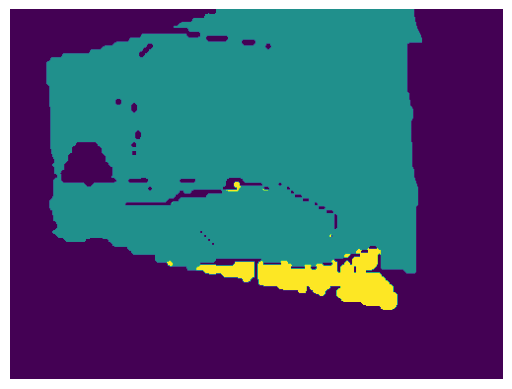

In [13]:
image_util.image_show(rw_pred)

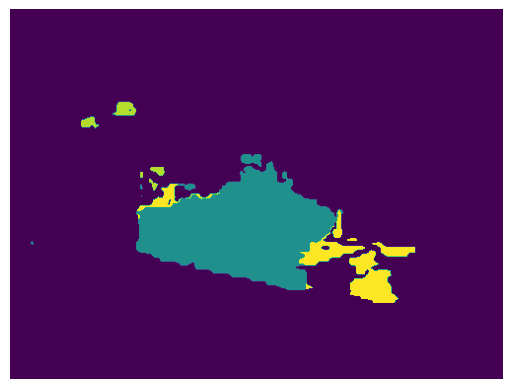

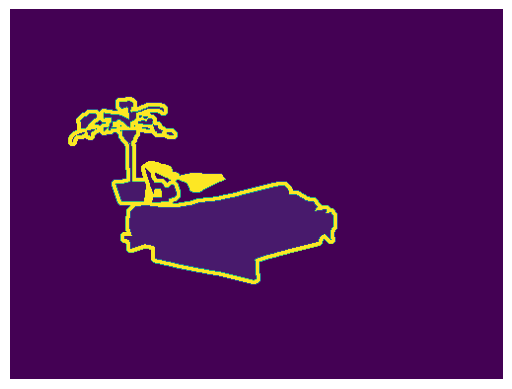

In [9]:
seg_root = "../irn_result/sem_seg/"
gt_root = "../Dataset/VOC2012/SegmentationClass/"

image_util.image_show(os.path.join(seg_root, name+".png"))
image_util.image_show(os.path.join(gt_root, name + ".png"))